## Train ReLayNet
RunFile of OCT segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformations
!pip install typing-extensions==3.7.4
!pip install comet_ml==3.1.8

In [ ]:
!pip install typing-extensions==3.6.6

In [ ]:
!pip install comet_ml

In [ ]:
from comet_ml import Experiment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

In [ ]:
from relaynet_pytorch.relay_net import ReLayNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
import glob
from pathlib import Path
from torch.utils.data import Dataset
import cv2
import numpy
from PIL import Image
#import transformations
from copy import deepcopy
#from torchvision import transforms
#import torchvision.transforms.functional as F
import random

class VData(Dataset):
    def __init__(self, parovi, mode):
        self.parovi = parovi
        self.mode = mode

    def custom_transform(self, og, mask, weights):
        height = 1024
        width = 512
        degrees, translate, scale_ranges, shears = transforms.RandomAffine.get_params((-10, 10), (-0.2, 0.2), None, None, (height, width))
        og = F.affine(og, degrees, translate, scale_ranges, shears)
        mask = F.affine(mask, degrees, translate, scale_ranges, shears)
        weights = F.affine(weights, degrees, translate, scale_ranges, shears)
        if random.random() > 0.5:
            og = F.hflip(og)
            mask = F.hflip(mask)
            weights = F.hflip(weights)
        return og, mask, weights

    def __getitem__(self, index):
        mask_img_rgb = Image.open(self.parovi[index][1])
        mask_img_grayscale = mask_img_rgb.convert('L')
        og_img_bgr = Image.open(self.parovi[index][0])
        og_img_gray = og_img_bgr.convert('L')
        if len(self.parovi[index]) == 3:
            weight_img_rgb = Image.open(self.parovi[index][2])
            weight_img_grayscale = weight_img_rgb.convert('L')

        #if self.mode == "train":
        #    og_img_gray, mask_img_grayscale, weight_img_grayscale = self.custom_transform(og_img_gray, mask_img_grayscale, weight_img_grayscale)
        mask_img = numpy.asarray(mask_img_grayscale)
        mask_img_normalized = mask_img.copy()
        numpy.place(mask_img_normalized, mask_img_normalized == 64, 1)
        numpy.place(mask_img_normalized, mask_img_normalized == 128, 2)
        numpy.place(mask_img_normalized, mask_img_normalized == 192, 3)
                    
        # og_img_bgr = cv2.imread(self.parovi[index][0])
        # og_img_gray = cv2.cvtColor(og_img_bgr, cv2.COLOR_BGR2GRAY)
        og_img_gray = numpy.asarray(og_img_gray)
        og_img_gray_max = numpy.max(og_img_gray[:])
        og_img_gray_min = numpy.min(og_img_gray[:])
        og_img_normalized = (og_img_gray - og_img_gray_min) / (og_img_gray_max - og_img_gray_min)
        og_img_normalized = numpy.expand_dims(og_img_normalized, axis=0)

        mask_img_normalized = mask_img_normalized.astype(numpy.float32)
        og_img_normalized = og_img_normalized.astype(numpy.float32)

        if len(self.parovi[index]) == 3:
            # weight_img_rgb = Image.open(self.parovi[index][2])
            # weight_img_grayscale = weight_img_rgb.convert('L')
            weight_img = numpy.asarray(weight_img_grayscale)
            weight_img_copy = weight_img.copy()
            weight_img_copy = weight_img_copy.astype(numpy.float32)
            numpy.place(weight_img_copy, weight_img_copy == 0, 1) # 1
            numpy.place(weight_img_copy, weight_img_copy == 100, 8) # 6
            numpy.place(weight_img_copy, weight_img_copy == 200, 15) # 11
            return og_img_normalized, mask_img_normalized, weight_img_copy

        return og_img_normalized, mask_img_normalized

    def __len__(self):
        return len(self.parovi)


def get_datasets():
    train_masks = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/train/*/mask/*")
    train_ogs = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/train/*/original/*")
    val_masks = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/val/*/mask/*")
    val_ogs = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/val/*/original/*")
    test_masks = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/test/*/mask/*")
    test_ogs = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/test/*/original/*")
    weights = glob.glob("/content/drive/My Drive/pacijenti_dataset_weights/train/*/weight/*")

    train_dataset = []
    val_dataset = []
    test_dataset = []

    train_masks_copy = deepcopy(train_masks)
    for mask_path in train_masks_copy:
        mask_path_copy = deepcopy(mask_path)
        original_path = mask_path_copy.replace("mask", "original")
        weight_path = mask_path_copy.replace("mask", "weight")
        weight_path = weight_path.replace(".tif", "_weights.tif")
        train_dataset.append([original_path, mask_path_copy, weight_path])

    for mask_path in val_masks:
        original_path = mask_path.replace("mask", "original")
        val_dataset.append([original_path, mask_path])

    for mask_path in test_masks:
        original_path = mask_path.replace("mask", "original")
        test_dataset.append([original_path, mask_path])

    return VData(train_dataset, mode="train"), VData(val_dataset, mode="val"), VData(test_dataset, mode="test")


In [ ]:
train_data, val_data, test_data = get_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 1118
Val size: 251
Test size: 61


In [ ]:
torch.cuda.is_available()

In [ ]:
from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':7,
        'kernel_w':3,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class':4
    }

exp_dir_name = 'Exp01'

experiment = Experiment("9LRg8JI8I44sbVgkkIuUnTwXr", "ReLayNet")
relaynet_model = ReLayNet(param)
solver = Solver()
solver.train(experiment, relaynet_model, train_loader, val_loader, test_loader, exp_dir_name=exp_dir_name)

In [ ]:
experiment.end()

In [ ]:
del relaynet_model

## Save the Model

When you are satisfied with your training, you can save the model.

In [ ]:
relaynet_model.save("models/relaynet_model.model")

# Deploy Model on Test Data

In [ ]:
SEG_LABELS_LIST = [
    {"id": 0, "name": "Vitreous", "rgb_values": [0, 0, 0]},
    {"id": 1, "name": "Inner Plexiform Layer", "rgb_values": [150, 0, 0]},
    {"id": 2, "name": "Inner Nuclear Layer", "rgb_values": [70, 150, 0]},
    {"id": 3, "name": "Pigment Epithelial Detachment", "rgb_values": [0, 0, 150]}];
    
def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


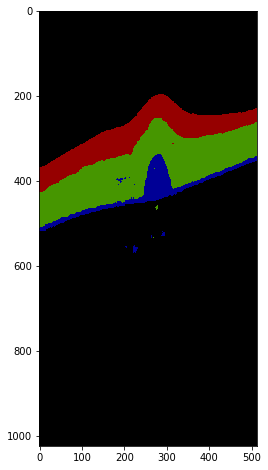

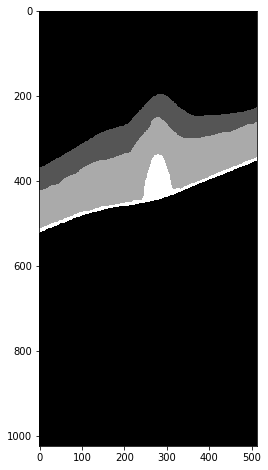

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)
relaynet_model =  torch.load("clweightsmodels/Exp01/relaynet_epoch26.model")
#relaynet_model =  torch.load("clnoweights/Exp01/relaynet_epoch15.model")
#relaynet_model =  torch.load("dicemodels/Exp01/relaynet_epoch18.model")
item = 7
out = relaynet_model(Variable(torch.Tensor(test_data.__getitem__(item)[0:1]).cuda(),volatile=True))
# out = F.softmax(out,dim=1)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = label_img_to_rgb(idx)
plt.imshow(idx)
plt.show()

#img_test = test_data.__getitem__(item)[0:1]
#img_test = np.squeeze(img_test)
#plt.imshow(img_test)
#plt.show()

img_test_mask = test_data.__getitem__(item)[1:2]
img_test_mask = np.squeeze(img_test_mask)
plt.imshow(img_test_mask)
plt.show()

In [ ]:
def per_class_dice(y_pred, y_true, num_class, list):
    y_pred = y_pred.data.cpu().numpy()  # [batch_size, 1024, 512]
    y_true = y_true.data.cpu().numpy()  # [batch_size, 1024, 512]
    pom = []
    avgdice = 0
    for i in range(num_class):
        inter = np.sum(y_pred[y_true == i] == i)
        union = np.sum(y_pred[y_pred == i] == i) + np.sum(y_true[y_true == i] == i)
        dice = 2 * inter / union
        pom.append(dice)
        avgdice += dice
    list.append(pom)
    return avgdice / num_class

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)
avg_dice = 0
dice_class_history = []
random = []
for i_batch, sample_batched in enumerate(test_loader):
    X = Variable(sample_batched[0].float())
    y = Variable(sample_batched[1].float())
    if relaynet_model.is_cuda:
        X, y = X.cuda(), y.cuda()
    output = relaynet_model(X)
    _, val_preds = torch.max(output, dim=1)
    print(i_batch, per_class_dice(val_preds, y, 4, random))
    avg_dice += per_class_dice(val_preds, y, 4, dice_class_history)
avg_dice_test = avg_dice / len(test_loader)
avg_dice_per_class = [0, 0, 0, 0]
for i in range(len(test_loader)):
    for j in range(4):
        avg_dice_per_class[j] += dice_class_history[i][j]
avg_dice_0 = avg_dice_per_class[0] / len(test_loader)
avg_dice_1 = avg_dice_per_class[1] / len(test_loader)
avg_dice_2 = avg_dice_per_class[2] / len(test_loader)
avg_dice_3 = avg_dice_per_class[3] / len(test_loader)

print("Average dice: " + str(avg_dice_test))
print("Per class dice: ", end="")
print(str(avg_dice_0) + " " + str(avg_dice_1) + " " + str(avg_dice_2) + " " + str(avg_dice_3))                        

0 0.9272681518754247
1 0.9406090163602594
2 0.8920207061252409
3 0.8534022415383825
4 0.9254510193721479
5 0.95237249604988
6 0.9395003918878374
7 0.9582933302593781
8 0.9343580910389907
9 0.9572421808929993
10 0.9250555823134866
11 0.9524816064107947
12 0.8928541845527833
13 0.8915700927164373
14 0.8882396092295871
15 0.9157980092810645
16 0.9154697828135161
17 0.9494021276316742
18 0.9474969011828617
19 0.8920975675753778
20 0.9310717324093067
21 0.8896118729291924
22 0.9245813493201978
23 0.921943077364064
24 0.8798024263927143
25 0.9230969310550894
26 0.9231193374264293
27 0.8928781839560781
28 0.928957049952501
29 0.9393483790669663
30 0.9104950702840039
31 0.9459535216342916
32 0.7901297076243181
33 0.8438304893871865
34 0.8348526758639334
35 0.8110142083048013
36 0.8315424347917613
37 0.8356269578727011
38 0.8394263334995805
39 0.8304391621009833
40 0.8656018531166415
41 0.8485370888171575
42 0.8210628078006464
43 0.8194758677606665
44 0.826743144016466
45 0.8474291367784171
46 